# Dog Rates Data Wrangling

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering</a></li>
<li><a href="#assess">Assessing</a></li>
<li><a href="#clean">Cleaning</a></li>
<li><a href="#analyze&visualize">Analyze and Visualize</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.

The data wrangling process will consist of 3 main steps. They are:
1. **Data gathering** - The data can be gathered in many ways including web scraping, using APIs etc. The data can be gathered from a single source or from many different sources.
2. **Assessing the data** - The data needs to assessed for quality and tidiness issues. This can be done visually and/or programatically.
3. **Cleaning the data** - Based on the assessment, the data is cleaned and tested to make sure all the issues identified are resolved.

**Analyze & Visualize**
<br/>
Finally, the wrangled data is analyzed and visualized in an effective and insightful manner.

>*Importing all necessary packages for the data wrangling and analysis*

In [1]:
import requests
import tweepy
import pandas as pd
import time
import json
from functools import reduce
import numpy as np
import ast

import matplotlib.pyplot as plt
%matplotlib inline

import config

In [2]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<a id='gather'></a>
## Gathering

> The data for this analysis is to be gathered from multiple sources. They are:
>
>> 1. The WeRateDogs Twitter archive is enhanced and provided. This file (**twitter_archive_enhanced.csv**) just needs to be downloaded.
>
>> 2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (**image_predictions.tsv**) is hosted on Udacity's servers and should be downloaded programmatically.
>
>> 3. Additional required and interesting data is to be obtained by querying the Twitter API for each tweet's JSON data and store each tweet's entire set of JSON data in a file (**tweet_json.txt**).

>*The file containing enhanced twitter archive (twitter_archive_enhanced.csv) has been manually downloaded and is available in the directory. The tweet image predictions file (image_predictions.tsv) is to be downloaded programmatically using the URL provided.*

In [3]:
# storing the URL provided in a variable
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# getting the response from the URL using requests library 
response = requests.get(url)

# with keyword ensures that the file is closed immediately the desired operation is complete
# file is opened for writing in binary mode
with open('image_predictions.tsv', 'wb') as file:
    # content of the response is written to the file
    file.write(response.content)

>*The file containing the image predictions is successfully saved in the working directory. Now, this data needs to be stored in a new dataframe for further steps of the data wrangling process. In order to read a TSV using pandas, the separator (sep) should be defined to be '\t'.*

In [4]:
image_predictions_df = pd.read_csv('image_predictions.tsv', sep='\t', index_col=None)
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


>*The additional data needs to be downloaded by querying the Twitter API using tweepy library. In order to do that, create a twitter developer account after signing in/up. Once the account is created, the consumer keys and authentication tokens will be available for use.*

>*It is not safe to expose the consumer keys and authentication tokens via code. Hence, a config file can used and imported in this notebook. (In order to execute the rest of the notebook, please fill in the necessary details in the config.py file)*

>*Authenticate using the consumer keys and set the access tokens.* 

In [5]:
# create an OAuthHandler instance
auth = tweepy.OAuthHandler(config.API_KEY, config.API_SECRET_KEY)
# set the access tokens
auth.set_access_token(config.ACCESS_TOKEN, config.ACCESS_TOKEN_SECRET)

# create the API instance
# wait_on_rate_limit – whether or not to automatically wait for rate limits to replenish
# wait_on_rate_limit_notify – whether or not to print a notification when Tweepy is waiting for rate limits to replenish
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
api

>*The API instance is created and ready for use now.*

>*The ID corresponding to each tweet is required in order to access the additional details of the tweet. These IDs are present in the twitter-archive-enhanced.csv file. Read the file and store as dataframe for further use.*

In [6]:
# read the file twitter-archive-enhanced.csv and store it in a dataframe 
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv', index_col=None, encoding = 'utf-8')
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [7]:
total_number_of_tweets = len(twitter_archive_df.tweet_id)
number_of_failures = 0
failed_tweets_dict = []

start = time.time()

# opening a text file in write mode and writing the JSON containing additional details of the tweet 
with open('tweet_json.txt', 'w') as txt_file:
    # looping over all the tweets whose IDs are present in the twitter_archive_df dataframe
    for tweet_id in twitter_archive_df.tweet_id:    
        try:
            # get a single status specified by the ID parameter
            # extended tweet mode gives the entire untruncated text of the Tweet
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, txt_file)
            txt_file.write('\n')
        except tweepy.TweepError as e:
            number_of_failures += 1
            failed_tweets_dict.append(tweet_id)
            print('Tweet ID:', tweet_id, '-', e)
            continue

print('Total number of tweets:', total_number_of_tweets)
print('Time taken:', (time.time()-start)/60, 'minutes')
print('Total number of failed tweets:', number_of_failures)
print('List of failed tweet IDs:', failed_tweets_dict)

Tweet ID: 888202515573088257 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 873697596434513921 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 872668790621863937 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 872261713294495745 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 869988702071779329 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 866816280283807744 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 861769973181624320 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 856602993587888130 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 851953902622658560 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 845459076796616705 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 844704788403113984 - [{'code': 144, 'message': 'No status found with that ID.'}]

Rate limit reached. Sleeping for: 424


Tweet ID: 754011816964026368 - [{'code': 144, 'message': 'No status found with that ID.'}]
Tweet ID: 680055455951884288 - [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 428


Total number of tweets: 2356
Time taken: 34.968524650732675 minutes
Total number of failed tweets: 25
List of failed tweet IDs: [888202515573088257, 873697596434513921, 872668790621863937, 872261713294495745, 869988702071779329, 866816280283807744, 861769973181624320, 856602993587888130, 851953902622658560, 845459076796616705, 844704788403113984, 842892208864923648, 837366284874571778, 837012587749474308, 829374341691346946, 827228250799742977, 812747805718642688, 802247111496568832, 779123168116150273, 775096608509886464, 771004394259247104, 770743923962707968, 759566828574212096, 754011816964026368, 680055455951884288]


>*Below are the explanations of the status codes for the errors:*<br/>
>>*Status code 144 - Corresponds with HTTP 404. The requested Tweet ID is not found (if it existed, it was probably deleted)*
>
>>*Status code 179 - Corresponds with HTTP 403. Thrown when a Tweet cannot be viewed by the authenticating user, usually due to the Tweet’s author having protected their Tweets.*

>*The additional data corresponding to all the tweets in the dataframe are available in tweet_json.txt file. The next step is to read the file and get the required data from JSONs (corresponding to each of the tweets). Finally, store the data in a new dataframe.*

In [8]:
additional_data = []

# opening the tweet_json.txt file in read mode 
with open('tweet_json.txt', 'r') as infile:
    # looping over each line of the file
    for record in infile:
        # convert string to JSON
        record_json_data = json.loads(record)
        # storing the required additional details in a list and appending it to the additional_data list
        additional_data.append([record_json_data['id'], record_json_data['retweet_count'], record_json_data['favorite_count'], record_json_data['created_at']])

# creating a new dataframe using the additional_data list of lists 
additional_data_df = pd.DataFrame(additional_data)
# defining the column names of the dataframe
additional_data_df.columns = ['tweet_id', 'retweet_count', 'favorite_count', 'created_at']
additional_data_df.head() 

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,7489,35454,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,5557,30692,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,3681,23084,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,7657,38727,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,8267,37002,Sat Jul 29 16:00:24 +0000 2017


>*Checking the number of records to confirm that all valid records in twitter_archive_df dataframe have a corresponding record in additional_data_df dataframe.*

In [9]:
additional_data_df.shape

(2331, 4)

>*We observe that except for the 25 tweet IDs that are not valid, there is one record for each tweet in the dataframe. The data gathering step is now complete.*

<a id='assess'></a>
## Assessing

>There are 2 types of issues that need to be assessed. They are:
>
>>1. Quality issues - issues with content. Low quality data is also known as dirty data.
>
>>2. Tidiness issues -  issues with structure that prevent easy analysis. Untidy data is also known as messy data. Tidy data requirements: 1.Each variable forms a column  2.Each observation forms a row  3.Each type of observational unit forms a table
>
>These issues can be assessed in 2 ways. They are:
>
>>1. Visual assessment - scrolling through the data in your preferred software application.
>
>>2. Programmatic assessment - using code to view specific portions and summaries of the data.

##### Visual assessement

#### 1. twitter_archive_df

In [10]:
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [11]:
twitter_archive_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [12]:
twitter_archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1624,684880619965411328,NaN,NaN,2016-01-06 23:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a basking dino pupper. Looks powerful. Occasionally shits eggs. Doesn't want the holidays to end. 5/10 https://t.co/DnNweb5eTO,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684880619965411328/photo/1,5,10,None,None,None,pupper,None
463,817423860136083457,NaN,NaN,2017-01-06 17:33:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ken. His cheeks are magic. 13/10 (IG: ken_shiba) https://t.co/btzf1zTDeQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817423860136083457/video/1,13,10,Ken,None,None,None,None
930,754449512966619136,NaN,NaN,2016-07-16 22:55:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Dex. He can see into your past and future. Mesmerizing af 11/10 https://t.co/0dYI0Cpdge,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754449512966619136/photo/1,11,10,Dex,None,None,None,None
467,817120970343411712,NaN,NaN,2017-01-05 21:29:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Name a more iconic quartet... I'll wait. 13/10 for all https://t.co/kCLgD8687T,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817120970343411712/photo/1,13,10,None,None,None,None,None
1458,695074328191332352,NaN,NaN,2016-02-04 02:40:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lorenzo. He's educated af. Just graduated college. 11/10 poor pupper can't even comprehend his debt https://t.co/dH3GzcjCtQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695074328191332352/photo/1,11,10,Lorenzo,None,None,pupper,None


>*From the visual assessment performed by scrolling through select records of the dataframe, the following are the issue(s) identified:*
>
>>*Quality issues:*
>
>>> 1) In `twitter_archive_df`, the collowing columns have missing values:
>
>>>>   i. `in_reply_to_status_id`
>
>>>>   ii. `in_reply_to_user_id`
>
>>>>   iii. `retweeted_status_id`
>
>>>>   iv. `retweeted_status_user_id`
>
>>>>   v. `retweeted_status_timestamp`
>
>>> 2) Some dog names are not valid (Eg. a, None)
>
>>> 3) Records corresponding to retweets should be removed
>
>>*Tidiness issue:*
>
>>>In `twitter_archive_df`, the following columns should be combined into one (as each variable should be represented in a single column):
>
>>>>   i. `doggo`
>
>>>>   ii. `floofer`
>
>>>>   iii. `pupper`
>
>>>>   iv. `puppo`

#### 2. image_predictions_df

In [13]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [14]:
image_predictions_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [15]:
image_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1196,740373189193256964,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True
1634,805958939288408065,https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg,1,Irish_setter,0.574557,True,golden_retriever,0.339251,True,seat_belt,0.046108,False
340,672248013293752320,https://pbs.twimg.com/media/CVROAIfWsAECA5t.jpg,1,Irish_terrier,0.413173,True,Airedale,0.335616,True,toy_poodle,0.027952,True
1338,758467244762497024,https://pbs.twimg.com/ext_tw_video_thumb/758467147756691456/pu/img/YTNzjRFDSPNXukmM.jpg,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
2007,877736472329191424,https://pbs.twimg.com/media/DC5YqoQW0AArOLH.jpg,2,Chesapeake_Bay_retriever,0.837956,True,Labrador_retriever,0.062034,True,Weimaraner,0.040599,True


>*From the visual assessment performed by scrolling through select records of the dataframe, the following are the issue(s) identified:*
>
>>*Quality issue:*
>
>>>The breeds of the dogs predicted in `p1`, `p2` and `p3` do not follow any standard naming (have underscores, lower case)
>
>>*Tidiness issue:*
>
>>>The `image_prediction_df` dataframe can be joined with the `twitter_archive_df`based on the tweet ID that is common for the two dataframes

#### 3. additional_data_df

In [16]:
additional_data_df.head()

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,7489,35454,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,5557,30692,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,3681,23084,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,7657,38727,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,8267,37002,Sat Jul 29 16:00:24 +0000 2017


In [17]:
additional_data_df.tail()

,tweet_id,retweet_count,favorite_count,created_at
2326,666049248165822465,40,96,Mon Nov 16 00:24:50 +0000 2015
2327,666044226329800704,125,264,Mon Nov 16 00:04:52 +0000 2015
2328,666033412701032449,39,109,Sun Nov 15 23:21:54 +0000 2015
2329,666029285002620928,41,119,Sun Nov 15 23:05:30 +0000 2015
2330,666020888022790149,454,2358,Sun Nov 15 22:32:08 +0000 2015


In [18]:
additional_data_df.sample(5)

,tweet_id,retweet_count,favorite_count,created_at
1978,672475084225949696,653,1363,Thu Dec 03 17:58:48 +0000 2015
2062,670797304698376195,218,693,Sun Nov 29 02:51:54 +0000 2015
261,840728873075638272,15579,0,Sun Mar 12 00:59:17 +0000 2017
345,829878982036299777,4917,0,Fri Feb 10 02:25:42 +0000 2017
714,781524693396357120,5524,20651,Thu Sep 29 16:03:01 +0000 2016


>*From the visual assessment performed by scrolling through select records of the dataframe, the following are the issue(s) identified:*
>
>>*Quality issue:*
>
>>>In `additional_data_df`, the `created_at` field is not in datetime format
>
>>*Tidiness issue:*
>
>>>The `additional_data_df` dataframe can be joined with the `twitter_archive_df` and `image_prediction_df` based on the tweet ID that is common for the three dataframes

##### Programmatic assessement

#### 1. twitter_archive_df

In [19]:
# getting the basic information including missing values and data types of the fields in the dataframe
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

>**Quality Issue(s):**
>
>1. The `timestamp` and `retweeted_status_timestamp` are not in datetime format
>
>2. The fields `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` and `retweeted_status_user_id` should be strings
>
>3. `expanded_urls` column has some missing values
>
>4. `tweet_id` should not an integer since numerical operations will not be performed

In [20]:
# getting the stats for the numerical fields in the dataframe
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [21]:
twitter_archive_df['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [22]:
twitter_archive_df['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

>**Quality Issue(s):**
>
>1. Looking at the minimum, maximum and other quartile values for numerator and denominator ratings, it looks like they are incorrect in some records
>
>2. `tweet_id` should not an integer since numerical operations will not be performed

In [23]:
# checking if there are any duplicate records in the dataframe
twitter_archive_df.duplicated().sum()

0

#### 2. image_prediction_df

In [24]:
# getting the basic information including missing values and data types of the fields in the dataframe
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


>**Quality Issue(s):**
>
>1. There are some missing records in the dataframe since the `twitter_archive_df` dataframe has 2356 records.This issue should be revisited after the dataframes are merged. 
>
>2. `tweet_id` should not an integer since numerical operations will not be performed

In [25]:
# checking if there are any duplicate records in the dataframe
image_predictions_df.duplicated().sum()

0

#### 3. additional_data_df

In [26]:
# getting the basic information including missing values and data types of the fields in the dataframe
additional_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   int64 
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
 3   created_at      2331 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.0+ KB


In [27]:
# checking if there are any duplicate records in the dataframe
additional_data_df.duplicated().sum()

0

>**Quality Issue(s):**
>
>There are some missing records in the dataframe since the `twitter_archive_df` dataframe has 2356 records (The missing 25 tweets had IDs that were not valid as discussed during data gathering). This issue should be revisited after the dataframes are merged. 

To summarize, the following are the quality and tidiness issues found in the data:

### Quality
##### `twitter_archive` table
- The following columns have missing values: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `expanded_urls`, and `retweeted_status_timestamp`
- Some dog names (`name`) are not valid (Eg. a, None)
- The `timestamp` and `retweeted_status_timestamp` are not in datetime format
- Incorrect `rating_numerator` and `rating_denominator` values
- The fields `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` and `retweeted_status_user_id` should be strings
- Records corresponding to retweets should be removed

##### `image_predictions` table
- Predicted breed of dogs in in `p1`, `p2` and `p3` do not follow any standard naming (have underscores, lower case)

##### `additional_data` table
- The `created_at` field is not in datetime format

##### `twitter_archive`, `image_predictions` & `additional_data` tables 
- `tweet_id` should not an integer since numerical operations will not be performed on it
- There are some missing records in `image_predictions` (2075 records) and `additional_data_df` (2331 records) when compared to the `twitter_archive_df` (2356 records). This should be revisited after merging the dataframes.

### Tidiness
- The three dataframes should be merged into one since "Each type of observational unit forms a table"
- The four columns in image_predictions_df dataframe - `doggo`, `floofer`, `pupper`, and `puppo` - should be combined into a single field since "Each variable forms a column"

>*The issues associated with the data are now assessed and segregated into quality and tidiness issues. The next step is to clean the data programmatically.*

<a id='clean'></a>
## Cleaning

>There are 2 types of cleaning. They are:
>
>>1. Manual (not recommended unless the issues are one-off occurrences)
>
>>2. Programmatic
>
>The programmatic data cleaning process includes 3 steps. They are:
>
>>1. Define: convert our assessments into defined cleaning tasks. These definitions also serve as an instruction list so others (or yourself in the future) can look at your work and reproduce it.
>
>>2. Code: convert those definitions to code and run that code.
>
>>3. Test: test your dataset, visually or with code, to make sure your cleaning operations worked.
>
>It is recommended to always make copies of the original pieces of data before cleaning.

In [28]:
# making copies of the dataframes
twitter_archive_clean_df = twitter_archive_df.copy()
image_predictions_clean_df = image_predictions_df.copy()
additional_data_clean_df = additional_data_df.copy()

### Missing Data

#### [Quality Issue 1]
#### `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `expanded_urls`, and 
#### `retweeted_status_timestamp`: Missing values

##### Define

There is no way to generate/get the values corresponding to `in_reply_to_status_id`, `in_reply_to_user_id`, and `expanded_urls`. Also, they are not necessary for further analysis. So these columns can be dropped. The fields `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are used to identify records corresponding to retweets. They will be used in order to resolve the issue of dropping records that correspond to retweets. This will result in empty columns for the fields. Then, the columns can be dropped.

##### Code

In [29]:
# dropping the columns inplace
twitter_archive_clean_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'expanded_urls'], axis=1, inplace=True)

##### Test

In [30]:
# checking if the columns have been dropped
twitter_archive_clean_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### Tidiness

#### [Tidiness Issue 1]
#### Merging the dataframes

##### Define

Inner join to be performed on the 3 dataframes. Since the merge() can join only 2 dataframes at a time, we use reduce() which is used to apply a particular function passed in its argument to all of the list elements mentioned in the sequence passed along. The inner join is peformed based on the `tweet_id`. In the case of an inner join, only the records in which `tweet_id` match in all the dataframes are present in the final dataframe.

##### Code

In [31]:
# creating a list containing all the dataframes to be merged
dfs = [twitter_archive_clean_df, image_predictions_clean_df, additional_data_clean_df]

# inner join is performed on the dataframes  
master_df = reduce(lambda left,right: pd.merge(left, right, on='tweet_id', how='inner'), dfs)
master_df.head()

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,created_at
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7489,35454,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5557,30692,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3681,23084,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7657,38727,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8267,37002,Sat Jul 29 16:00:24 +0000 2017


In [32]:
# getting missing value count and data types of all the columns of the merged dataframe
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   timestamp                   2059 non-null   object 
 2   source                      2059 non-null   object 
 3   text                        2059 non-null   object 
 4   retweeted_status_id         72 non-null     float64
 5   retweeted_status_user_id    72 non-null     float64
 6   retweeted_status_timestamp  72 non-null     object 
 7   rating_numerator            2059 non-null   int64  
 8   rating_denominator          2059 non-null   int64  
 9   name                        2059 non-null   object 
 10  doggo                       2059 non-null   object 
 11  floofer                     2059 non-null   object 
 12  pupper                      2059 non-null   object 
 13  puppo                       2059 

##### Test

In [33]:
# checking the shape of the merged dataframe
master_df.shape

(2059, 28)

In [34]:
# checking the columns of the merged dataframe
master_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count',
       'favorite_count', 'created_at'],
      dtype='object')

#### [Tidiness Issue 2]
#### Maintaining single column for dog stage

##### Define

The 4 columns corresponding to each stage are to be combined into one column. First, we have to check if each dog is classified as only one stage and get the required numbers for verification after cleaning. Next, we need to combine the 4 columns to get a single column containing a list of all their values. Finally, we get a list of unique values for each list. If the list consists of only one stage, then no operation should be performed else, all the 'None' values are removed. The resulting list is considered as the list of stages of the dog.  

##### Code

Getting the expected number of each stage

In [35]:
master_df.doggo.value_counts()

None     1981
doggo      78
Name: doggo, dtype: int64

In [36]:
master_df.floofer.value_counts()

None       2051
floofer       8
Name: floofer, dtype: int64

In [37]:
master_df.pupper.value_counts()

None      1838
pupper     221
Name: pupper, dtype: int64

In [38]:
master_df.puppo.value_counts()

None     2035
puppo      24
Name: puppo, dtype: int64

In [39]:
master_df[(master_df.doggo == 'None') & (master_df.floofer == 'None') & (master_df.pupper == 'None') & (master_df.puppo == 'None')].count()[0]

1741

In summary,

Number of doggos = 78 <br/>
Number of floofers = 8 <br/>
Number of puppers = 221 <br/>
Number of puppos = 24 <br/>
Number of Nones = 1741 <br/>

These numbers do not add up to the total number of records (2059). Hence, we can infer that few of the dogs are categorized under more than one stage. 

In [40]:
# combining the columns into a single column of stages
master_df['dog_stages']= master_df[['doggo', 'floofer', 'pupper', 'puppo']].values.tolist()

# dropping the individual stage columns
master_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [41]:
# creating a new column in the dataframe to hold the final values of the dog stage(s)
master_df['dog_stage'] = pd.Series()

for index, row in master_df.iterrows():
    # getting unique list of stage(s) of the dog
    stages = list(set(row.dog_stages))
    # if the list has more than one value, remove 'None' from the list
    if len(stages) > 1:
        stages.remove('None')
    # assigning the (string representation) list of stages under which the dog is categorized 
    master_df.loc[index, 'dog_stage'] = str(stages)

# drop the intermediate dog_stages column
master_df.drop('dog_stages', axis=1, inplace=True)
    
master_df.head()

/mnt/f/virtualenvs/data_wrangling/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,created_at,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7489,35454,Tue Aug 01 16:23:56 +0000 2017,['None']
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5557,30692,Tue Aug 01 00:17:27 +0000 2017,['None']
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3681,23084,Mon Jul 31 00:18:03 +0000 2017,['None']
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7657,38727,Sun Jul 30 15:58:51 +0000 2017,['None']
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8267,37002,Sat Jul 29 16:00:24 +0000 2017,['None']


In [42]:
# getting data types and missing values of each field
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   int64  
 1   timestamp                   2059 non-null   object 
 2   source                      2059 non-null   object 
 3   text                        2059 non-null   object 
 4   retweeted_status_id         72 non-null     float64
 5   retweeted_status_user_id    72 non-null     float64
 6   retweeted_status_timestamp  72 non-null     object 
 7   rating_numerator            2059 non-null   int64  
 8   rating_denominator          2059 non-null   int64  
 9   name                        2059 non-null   object 
 10  jpg_url                     2059 non-null   object 
 11  img_num                     2059 non-null   int64  
 12  p1                          2059 non-null   object 
 13  p1_conf                     2059 

##### Test

In [43]:
# checking the shape of the dataframe
master_df.shape

(2059, 25)

In [44]:
# checking the columns of the dataframe
master_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweet_count', 'favorite_count', 'created_at', 'dog_stage'],
      dtype='object')

In [45]:
# get the distribution of dog stages in the dataset
master_df.dog_stage.value_counts()

['None']                1741
['pupper']               210
['doggo']                 65
['puppo']                 23
['pupper', 'doggo']       11
['floofer']                7
['doggo', 'floofer']       1
['puppo', 'doggo']         1
Name: dog_stage, dtype: int64

### Quality

#### [Quality Issue 2]
#### Remove records corresponding to retweets

##### Define

Only original tweets are to be considered for analysis. The records corresponding to retweets can be identified by the fact that the fields `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` have some value. In all the other cases, it is NaN. So, the task is to remove all the records for which the retweet related values are available.

##### Code

In [46]:
# get shape of the dataframe for future verification
master_df.shape

(2059, 25)

In [47]:
# create a dataframe containing the records to the dropped (corresponding to retweets)
filtered_df = master_df[(master_df.retweeted_status_id.notnull()) & (master_df.retweeted_status_user_id.notnull()) & (master_df.retweeted_status_timestamp.notnull())]

# drop the records corresponding to retweets
master_df.drop(filtered_df.index, inplace = True)

In [48]:
# the columns corresponding to retweets will now have only null values and hence can be dropped
master_df.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace = True)

##### Test

In [49]:
# getting the shape to verify that 72 records have been dropped
master_df.shape 

(1987, 22)

#### [Quality Issue 3]
#### Incorrect `rating_denominator` values

##### Define

The denominator value should always be 10. We should first take a look at all the cases where the denominator is greater than 10 and decide if we can update the denominator of the rating to 10 and check the corresponding numerators as well.

##### Code

In [50]:
# getting all the records where denominator of the rating is greater than 10
master_df[master_df['rating_denominator'] > 10][['tweet_id', 'text', 'rating_denominator', 'rating_numerator']]

,tweet_id,text,rating_denominator,rating_numerator
336,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,84
722,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150,165
863,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11,9
911,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170,204
954,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20,4
988,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1009,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90,99
1034,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1052,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50,45
1118,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,50,60


Looking at the `text` corresponding to each of the records, we can see that it is because there are multiple dogs are being rated. Naturally, the numerators of the corresponding ratings should also be fixed. 

In two record with tweet_ids 682962037429899265 and 740373189193256964, the wrong fraction has been picked up. These can be changed.

In [51]:
# getting all the records where denominator of the rating is greater than 10 and is a multiple of 10
master_df[(master_df['rating_denominator'] > 10) & (master_df['rating_denominator'] % 10 == 0)][['tweet_id', 'text', 'rating_denominator', 'rating_numerator']]

,tweet_id,text,rating_denominator,rating_numerator
336,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,84
722,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150,165
911,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170,204
954,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20,4
988,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1009,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90,99
1034,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1052,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50,45
1118,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,50,60
1194,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,40,44


In [52]:
# creating a dataframe with the required conditions
filtered_df = master_df.loc[(master_df['rating_denominator'] > 10) & (master_df['rating_denominator'] % 10 == 0)]

# iterrating through the records to update the numerator and denominator
for index, row in filtered_df.iterrows():
    # since there are multiple dogs, divide by number of dogs
    master_df.loc[index, 'rating_numerator'] = row.rating_numerator/(row.rating_denominator/10)
    master_df.loc[index, 'rating_denominator'] = 10   ### row.rating_denominator/(row.rating_denominator/10)

In [53]:
# checking for other records with denominator of the rating greater than 10
master_df[master_df['rating_denominator'] > 10][['tweet_id', 'text', 'rating_denominator', 'rating_numerator']]

,tweet_id,text,rating_denominator,rating_numerator
863,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11,9
1392,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,11,7


In [54]:
# the numerators and denominators of the ratings of the tweets are updated using the text
master_df.loc[(master_df['tweet_id'] == 682962037429899265), 'rating_denominator'] = 10
master_df.loc[(master_df['tweet_id'] == 682962037429899265), 'rating_numerator'] = 10

master_df.loc[(master_df['tweet_id'] == 740373189193256964), 'rating_denominator'] = 10
master_df.loc[(master_df['tweet_id'] == 740373189193256964), 'rating_numerator'] = 14

##### Test

In [55]:
# checking if there are any more records where denominator of the rating is greater than 10
master_df[master_df['rating_denominator']>10][['tweet_id', 'text', 'rating_denominator', 'rating_numerator']].count()[0]

0

#### [Quality Issue 4]
#### Incorrect `rating_numerator` values

##### Define

Firstly, check the records with numerator greater than 20 since it has been established that most of the ratings are  intentionally assigned a rating with numerator greater than 10. From the text, update the numerators. Wherever there is no rating or the rating is invalid, set the numerator and denominator to 10.

##### Code

In [56]:
# getting all the records where numerator of the rating is greater than 20
master_df[master_df['rating_numerator'] >= 20][['tweet_id', 'text', 'rating_denominator', 'rating_numerator']]

,tweet_id,text,rating_denominator,rating_numerator
406,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7,24
548,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10,75
603,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,10,27
789,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,10,1776
1438,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,10,26
1781,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,10,420


In [57]:
# the numerators and denominators of the ratings of the tweets are updated using the text
master_df.loc[(master_df['tweet_id'] == 786709082849828864), 'rating_numerator'] = 9.75
master_df.loc[(master_df['tweet_id'] == 778027034220126208), 'rating_numerator'] = 11.27
master_df.loc[(master_df['tweet_id'] == 749981277374128128), 'rating_numerator'] = 17.76
master_df.loc[(master_df['tweet_id'] == 680494726643068929), 'rating_numerator'] = 11.26

# approximating numerator and denominator to 10 wherever there is no rating/no valid rating in the text
master_df.loc[(master_df['tweet_id'] == 670842764863651840), 'rating_numerator'] = 10

master_df.loc[(master_df['tweet_id'] == 810984652412424192), 'rating_numerator'] = 10
master_df.loc[(master_df['tweet_id'] == 810984652412424192), 'rating_numerator'] = 10

##### Test

In [58]:
# checking if there are any more records where numerator of the rating is greater than 20
master_df[master_df['rating_numerator'] >= 20][['tweet_id', 'text', 'rating_denominator', 'rating_numerator']].count()[0]

0

#### [Quality Issue 5]
#### Invalid dog names

##### Define

The `name` column in the dataframe has many invalid names such as 'a', 'quite', 'one', 'an' etc and many None values. We can observe that the names that are invalid are lowercase strings. Using this common property, we can update the names to 'None'.

##### Code

In [59]:
# getting number of records with name as 'None'
master_df[master_df.name == 'None']['name'].count()

546

In [60]:
# getting number of records with invalid names
master_df[master_df.name.str.islower()]['name'].count()

98

In [61]:
# getting all records with invalid names
master_df[master_df.name.str.islower()][['tweet_id', 'text', 'name']]

,tweet_id,text,name
21,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,such
50,881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
138,859196978902773760,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,quite
152,855459453768019968,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",quite
284,828650029636317184,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
429,806219024703037440,We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,incredibly
514,792913359805018113,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
636,772581559778025472,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
651,770655142660169732,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10 https://t.co/qlUDuPoE3d,very
679,765395769549590528,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my


In [62]:
# updating records with invalid names to 'None'
master_df.loc[master_df.name.str.islower(), 'name'] = 'None'

##### Test

In [63]:
# verifying that there are no invalid names in the dataframe
master_df[master_df.name.str.islower()][['tweet_id', 'text', 'name']].count()[0]

0

In [64]:
# getting the total number of records for which name is not available
master_df[master_df.name == 'None'][['tweet_id', 'text', 'name']].count()[0]

644

#### [Quality Issue 6]
#### Naming convention of breed of dog

##### Define

The predicted values of the breed of the dog present the columns `p1`, `p2` and `p3` have underscores separating the words. The case of the words are also not consistent. We can convert to title case and replace all occurences of underscores with spaces.

##### Code

In [65]:
# getting a sample of the required columns for analysis
master_df[['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
1673,hamster,weasel,Pomeranian
1924,standard_poodle,Bedlington_terrier,Afghan_hound
1896,cocker_spaniel,Lakeland_terrier,soft-coated_wheaten_terrier
221,Leonberg,Newfoundland,Saint_Bernard
477,American_Staffordshire_terrier,Chihuahua,Staffordshire_bullterrier
1802,Norfolk_terrier,golden_retriever,television
1011,Great_Pyrenees,Samoyed,kuvasz
1565,bath_towel,Staffordshire_bullterrier,bagel
1671,golden_retriever,Labrador_retriever,kuvasz
708,balloon,confectionery,maraca


In [66]:
# converting to title case + replacing underscores with spaces
master_df['p1'] = master_df['p1'].str.title().str.replace('_', ' ')
master_df['p2'] = master_df['p2'].str.title().str.replace('_', ' ')
master_df['p3'] = master_df['p3'].str.title().str.replace('_', ' ')

##### Test

In [67]:
# checking if the breads of the dogs is formatted consistently by getting a sample of 10
master_df[['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
1574,Box Turtle,Terrapin,Loggerhead
1642,Collie,Borzoi,Shetland Sheepdog
936,Flat-Coated Retriever,Great Dane,Labrador Retriever
658,Golden Retriever,Pekinese,Cocker Spaniel
695,Gondola,Sea Lion,Pool Table
1881,Minivan,Police Van,Minibus
5,Chesapeake Bay Retriever,Irish Terrier,Indian Elephant
214,Web Site,Rule,Envelope
1368,Llama,Ram,Hog
446,Golden Retriever,Labrador Retriever,Cocker Spaniel


#### [Quality Issue 7]
#### `tweet_id` datatype

##### Define

`tweet_id` is of integer type in the dataframe. It is not meaningful to perform any numerical operations on the tweet IDs. For example, adding two tweet IDs does not result in any meaningful output. Thus, we can convert it to string datatype.

##### Code

In [68]:
# converting tweet_id from integer to string
master_df.tweet_id = master_df.tweet_id.astype(str)

##### Test

In [69]:
# checking the datatype of tweet_id 
# we should be 'O' which represents Object (string)
master_df.tweet_id.dtype

dtype('O')

#### [Quality Issue 8]
#### `timestamp` and `created_at` datatype

##### Define

The `timestamp` and `created_at` columns have are strings (objects). They look like they have the same values, this needs to be checked. If they are duplicates, one of the columns needs to be dropped. We need to convert them to datetime format using to_datetime() if we want to use the field for further analysis.

##### Code

In [70]:
# checking if the columns have the same values
master_df[master_df.timestamp != master_df.created_at].shape

(1987, 22)

In [71]:
# since the columns have same values, timestamp can be dropped without loosing any data
master_df.drop('timestamp', axis=1, inplace=True)

In [72]:
# converting created_at to datetime format
master_df.created_at = pd.to_datetime(master_df.created_at)

##### Test

In [73]:
# checking the datatype of created_at 
master_df.created_at.dtype

datetime64[ns, UTC]

In [74]:
master_df.shape

(1987, 21)

The dataset is now clean and ready for analysis.

## Storing the data

The data can be stored in a flat file (CSV, TSV etc) or in a database. In this case, we will store the data in a CSV file named twitter_archive_master.csv using the to_csv().

In [75]:
master_df.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze&visualize'></a>
## Analyze and Visualize

During the stage, we analyze the data to get the answers to questions that we pose. The results are further visualized by using different types of graphs. Visualizing the results is of utmost importance when we are trying to convey a message or an idea to someone else. It helps give a clear picture and solidify the take aways. 

Let us consider the following questions:
<ol>
    <li><a href="#q1">What is the monthly trend of the favorite count?</a></li>
    <li><a href="#q2">What are the details of the tweet that was retweeted the most?</a></li>
    <li><a href="#q3"> What is the relationship between rating and number of retweets?</a></li>
    <li><a href="#q4">In how many tweets was the rating given greater than 10?</a></li>
    <li><a href="#q5">Which dog stage is occurs most frequently?</a></li>
</ol>

In order to answer the questions listed above, we do not require all the fields currently present in twitter_archive_master.csv. We can drop the fields that are not required - `source`, `jpg_url`, `img_num`, `p1`, `p1_conf`, `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, and `p3_dog`.

In [76]:
master_df.drop(['source', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

In [77]:
master_df.columns

Index(['tweet_id', 'text', 'rating_numerator', 'rating_denominator', 'name',
       'retweet_count', 'favorite_count', 'created_at', 'dog_stage'],
      dtype='object')

### Utility Functions

This section consists of functions that will be used regularly throughout this analysis.

In [78]:
# function used to plot a line graph
def draw_line_graph(x, y, x_label, y_label, title, rotation=0):
    plt.figure(figsize=(10, 10))
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.grid();

In [79]:
# function used to plot a bar graph
def draw_bar_graph(x, y, x_label, y_label, title, rotation=0):
    plt.figure(figsize=(10, 10))
    plt.bar([2, 4, 6, 8, 10], y, tick_label=x)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.grid();

In [80]:
# function used to plot a scatter plot
def draw_scatter_plot(x, y, x_label, y_label, title, ticks, rotation=0):
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(ticks, ticks)
    plt.xticks(rotation=rotation)
    plt.grid();

In [81]:
# function used to plot a histogram
def draw_histogram(x, no_of_bins, x_label, y_label, title, ticks):
    plt.figure(figsize=(10, 10))
    n, bins, patches = plt.hist(x, no_of_bins)
    plt.xticks(ticks, ticks)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid();

<a id='q1'></a>
### Question 1: What is the monthly trend of the followers count?

Firstly, we need to extract the month and year from the `created_at` field. The average number of followers is found after grouping by month. The data is further used to plot a line graph representing the trend. 

In [82]:
# extracting month and year from created_at
master_df['month'] = pd.DatetimeIndex(master_df['created_at']).month_name()
master_df['year'] = pd.DatetimeIndex(master_df['created_at']).year
master_df.head()

,tweet_id,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,created_at,dog_stage,month,year
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10,Phineas,7489,35454,2017-08-01 16:23:56+00:00,['None'],August,2017
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10,Tilly,5557,30692,2017-08-01 00:17:27+00:00,['None'],August,2017
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10,Archie,3681,23084,2017-07-31 00:18:03+00:00,['None'],July,2017
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10,Darla,7657,38727,2017-07-30 15:58:51+00:00,['None'],July,2017
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10,Franklin,8267,37002,2017-07-29 16:00:24+00:00,['None'],July,2017


In [83]:
master_df['month'].unique()

array(['August', 'July', 'June', 'May', 'April', 'March', 'February',
       'January', 'December', 'November', 'October', 'September'],
      dtype=object)

In [84]:
master_df['year'].unique()

array([2017, 2016, 2015])

In [85]:
# making month field (ordered) categorical 
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
master_df['month'] = pd.Categorical(master_df.month, ordered=True, categories=months)

In [86]:
master_df.columns

Index(['tweet_id', 'text', 'rating_numerator', 'rating_denominator', 'name',
       'retweet_count', 'favorite_count', 'created_at', 'dog_stage', 'month',
       'year'],
      dtype='object')

In [87]:
# getting the average favorite count after grouping by month
favorite_count = master_df.groupby('month').favorite_count.mean()
favorite_count

month
January       7631.382979
February      8540.574713
March         7941.457831
April        11506.042105
May          14828.870000
June         15406.758065
July         14638.132353
August       10088.196721
September    10162.112903
October      11874.907692
November      2978.524355
December      4701.740476
Name: favorite_count, dtype: float64

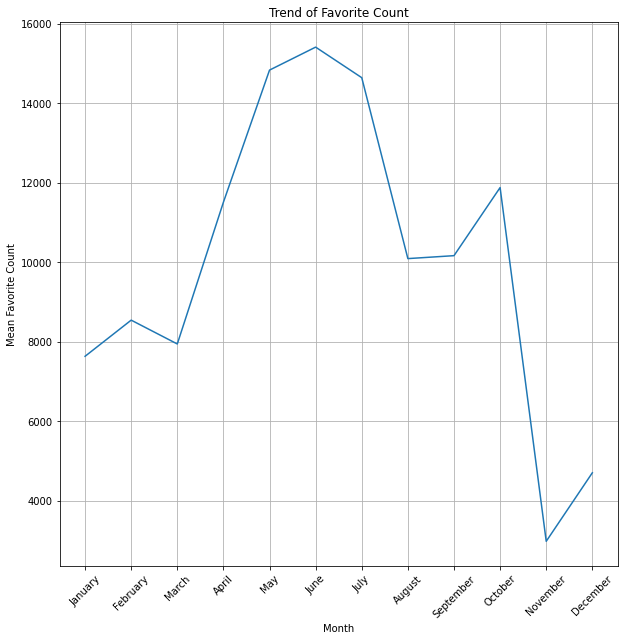

In [88]:
# calling the utility function to plot the graph
draw_line_graph(favorite_count.index, favorite_count.values, 'Month', 'Mean Favorite Count', 'Trend of Favorite Count', 45)

From the above line plot, we can observe that the month of June has the highest number of average followers count while November has the lowest number. There is however, no consistent trend throughout the year.

<a id='q2'></a>
### Question 2: What are the details of the tweet that was retweeted the most?

The top 5 most retweeted tweet's records can be obtained by using the .nlargest() with the parameter as the `retweet_count`. These tweets' retweet count can be compared visually by plotting a bar graph. The tweets can be identifed by a concise alpha numeric rather than the `tweet_id` in the graph for a cleaner presentation. The details of the most retweeted tweet is obtained by looking at all the fields and summarizing the details.

In [89]:
# getting 5 tweets with maximum retweet count
top_5_tweets = master_df.nlargest(5, 'retweet_count')

# identifying the tweets using a consise ID
top_5_tweets['tweet_identifier'] = ['T1', 'T2', 'T3', 'T4', 'T5']

top_5_tweets

,tweet_id,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,created_at,dog_stage,month,year,tweet_identifier
838,744234799360020481,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,10,None,75691,152854,2016-06-18 18:26:18+00:00,['doggo'],June,2016,T1
873,739238157791694849,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,10,None,56315,112988,2016-06-04 23:31:25+00:00,['doggo'],June,2016,T2
423,807106840509214720,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,10,Stephan,55172,118031,2016-12-09 06:17:20+00:00,['None'],December,2016,T3
320,822872901745569793,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,10,None,42625,130351,2017-01-21 18:26:02+00:00,['puppo'],January,2017,T4
59,879415818425184262,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13.0,10,Duddles,39652,97380,2017-06-26 19:07:24+00:00,['None'],June,2017,T5


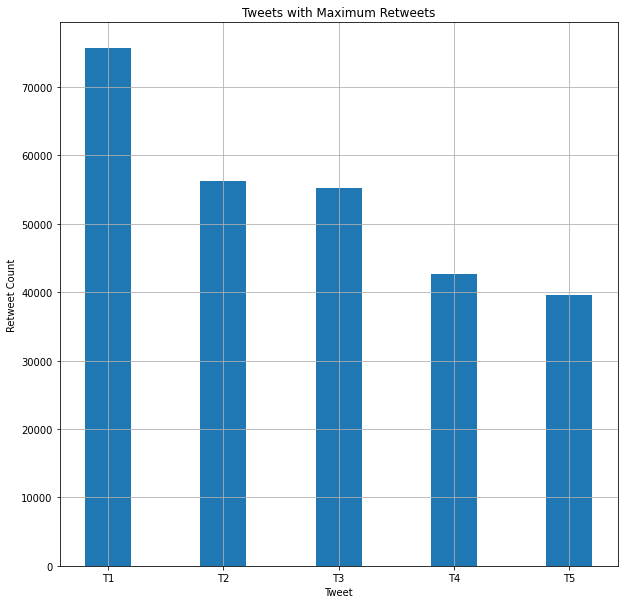

In [90]:
# calling the utility function to plot the graph
draw_bar_graph(top_5_tweets['tweet_identifier'], top_5_tweets['retweet_count'], 'Tweet', 'Retweet Count', 'Tweets with Maximum Retweets')

In the tweet with maximum number of retweets (identified by T1), the dog is rated 13/10. The name is the dog is not available and the stage is 'doggo'. The tweet was created on 18th June, 2016.  

<a id='q3'></a>
### Question 3: What is the relationship between rating and number of retweets?

The relationship between rating and number of retweets associated with a tweet can be visualized using a scatter plot. We can use the `rating_numerator` to represent the rating since the `rating_denominator` is always 10.

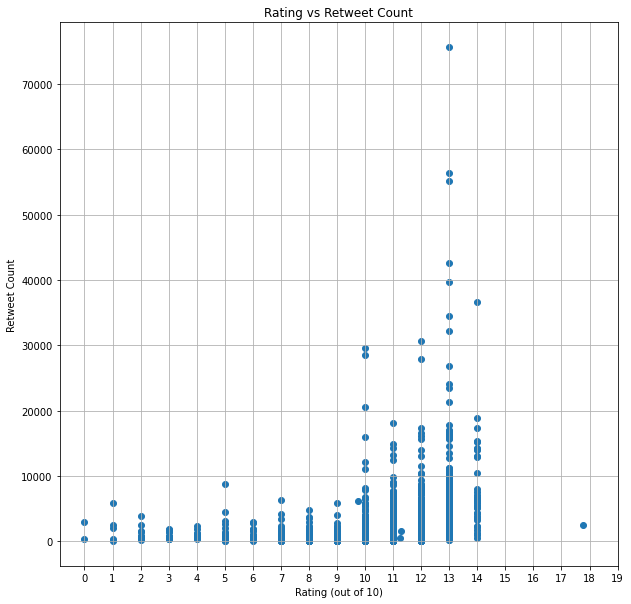

In [91]:
# getting the required X ticks
ticks = np.arange(0, 20)

# calling the utility function to plot the graph
draw_scatter_plot(master_df.rating_numerator, master_df.retweet_count, 'Rating (out of 10)', 'Retweet Count', 'Rating vs Retweet Count', ticks)

In [92]:
master_df.groupby('rating_numerator').retweet_count.max()

rating_numerator
0.00      2934
1.00      5828
2.00      3781
3.00      1898
4.00      2335
5.00      8783
6.00      2901
7.00      6347
8.00      4740
9.00      5800
9.75      6091
10.00    29583
11.00    18100
11.26      470
11.27     1591
12.00    30592
13.00    75691
14.00    36562
17.76     2412
Name: retweet_count, dtype: int64

From the scatter plot above, we can make the following inferences:
> 1. The maximum number of retweets for each rating does not demonstrate any strict trends
>
> 2. The maximum number of retweets were recorded for a dog with a 13/10 rating

<a id='q4'></a>
### Question 4: In how many tweets was the rating given greater than 10?

The denominator of the rating is always 10. The numerator can be greater than, lesser than or equal to 10. We can apply a condition to get the number of tweets that have rating greater than 10. The same can be visualized using a histogram.

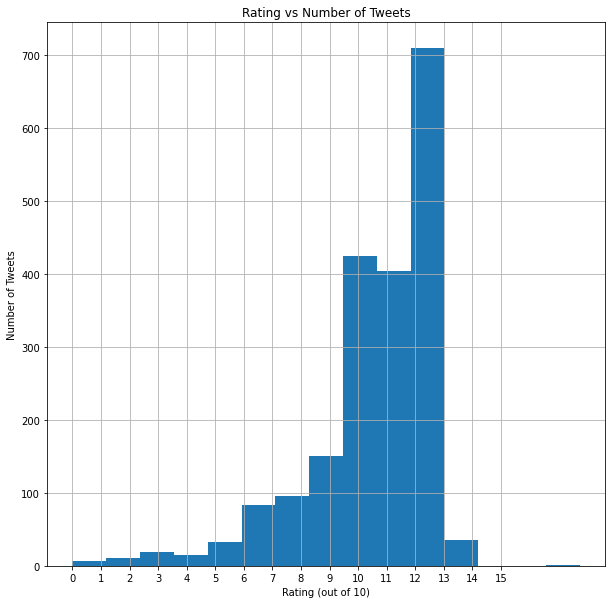

In [93]:
# defining the ticks for the plot
ticks = np.arange(0, 16)

# calling the utility function to plot the graph
draw_histogram(master_df.rating_numerator, 15, 'Rating (out of 10)', 'Number of Tweets', 'Rating vs Number of Tweets', ticks)

In [94]:
# getting the number of ratings greater than 10
master_df[master_df.rating_numerator > 10].count()[0]

1150

We can observe from the above graph that the majority of the dogs are given a rating above 10, out of 10. This is a unique system of @dog_rates. The graph is heavily left-skewed. From the calculations, 1150 out of the 1987 tweets have a dog rating above 10.  

<a id='q5'></a>
### Question 5: Which dog stage is occurs most frequently?

In [95]:
# dictionary containing dog stage as key and count as value
dog_stage_count = {"doggo": 0, "floofer": 0, "pupper": 0, "puppo": 0, "None": 0}

# populate count of the dog stages in the dictionary
for stages in master_df.dog_stage:
    stages = ast.literal_eval(stages)
    for stage in stages:
        dog_stage_count[stage] += 1
        
dog_stage_count

{'doggo': 73, 'floofer': 8, 'pupper': 212, 'puppo': 23, 'None': 1682}

In [96]:
# populating lists as preparation for plotting the graph
dog_stages = []
counts = []

for dog_stage, count in dog_stage_count.items():
        dog_stages.append(dog_stage)
        counts.append(count)

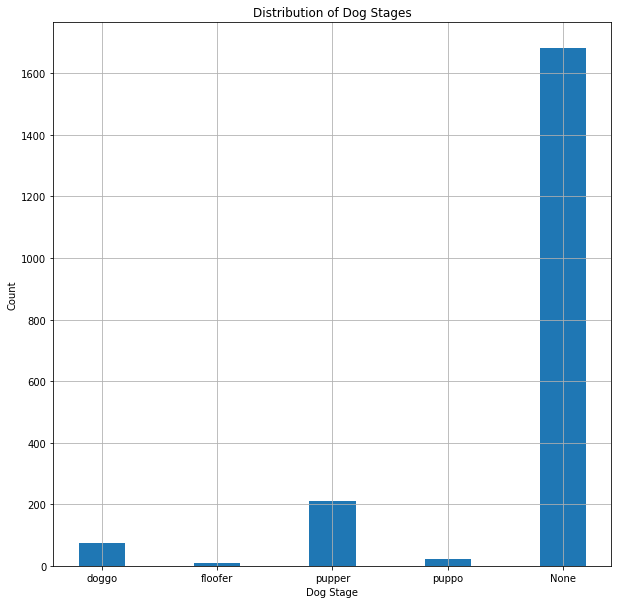

In [97]:
# calling the utility function to plot the graph
draw_bar_graph(dog_stages, counts, 'Dog Stage', 'Count', 'Distribution of Dog Stages')

Most of the stages corresponding to the dogs are None. Among the 4 stages, pupper is the most common stage in the dataset.

<a id='conclusion'></a>
## Conclusion

>*CONCLUDING REMARKS:*
>
> 1. **June** has most average favorite count while **November** has the least. There is no consistent trend over the months.
> 
> 2. The tweet with maximum number of retweets (identified by T1) has a **13/10** dog rating. The name is the dog is not available and the stage is **'doggo'**. The tweet was created on **18th June, 2016**.
>
> 3. There is **no strict relationship** between the dog ratings and the number of retweets. The tweet with maximum retweets has a rating of 13/10.
>
> 4. Approximately **58%** (1150/1987 tweets) of the tweets have a dog rating above 10.
>
> 5. Among the valid dog stages, **pupper** is the most common with 212 occurences.

Please note that the data wrangling and analysis is not exhaustive. There are many more quality and tidiness issues that have not been adressed in this notebook. There are lots of other questions that can be posed and the answers visualized.

The analyses and visualizations are based on the assessed anf cleaned data.

>*REFERENCES:*
> 
> 1. Get tweets with specific ID using Twitter API - https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
>
> 2. Response codes for Twitter API - https://developer.twitter.com/ja/docs/basics/response-codes
>
> 3. Joining multiple dataframes at once - https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
>
> 4. Combine column values into a list in a new column - https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column/43898233
>
> 5. Official Documentation - requests, tweepy, pandas, matplotlib